In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import arviz as az
import pymc as pm
import pymc.sampling_jax
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

/Users/corrado/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
y = np.array(
    [
        26.0,
        35.0,
        30,
        25,
        44,
        30,
        33,
        43,
        22,
        43,
        24,
        19,
        39,
        31,
        25,
        28,
        35,
        30,
        26,
        31,
        41,
        36,
        26,
        35,
        33,
        28,
        27,
        34,
        27,
        22,
    ]
)

df = pd.DataFrame()
df["y"] = y

In [4]:
np.mean(y)

30.933333333333334

In [5]:
def metropolis(logp, qdraw, stepsize, nsamp, xinit):
    samples = np.empty(nsamp)
    x_prev = xinit
    accepted = 0
    for i in range(nsamp):
        x_star = qdraw(x_prev, stepsize)
        logp_star = logp(x_star)
        logp_prev = logp(x_prev)
        logpdfratio = logp_star - logp_prev
        u = np.random.uniform()
        if np.log(u) <= logpdfratio:
            samples[i] = x_star
            x_prev = x_star
            accepted += 1
        else:  # we always get a sample
            samples[i] = x_prev

    return samples, accepted

In [6]:
def prop(x, step):
    return np.random.normal(x, step)

In [7]:
# Prior mean
mu_prior = 30
# prior std
std_prior = 5

In [8]:
logprior = lambda mu: stats.norm.logpdf(mu, loc=mu_prior, scale=std_prior)
loglike = lambda mu: np.sum(stats.norm.logpdf(y, loc=mu, scale=np.std(y)))
logpost = lambda mu: loglike(mu) + logprior(mu)

In [9]:
x0 = np.random.uniform()
nsamps = 100000

samps, acc = metropolis(logpost, prop, 3, nsamps, x0)

In [10]:
acc / nsamps

0.41772

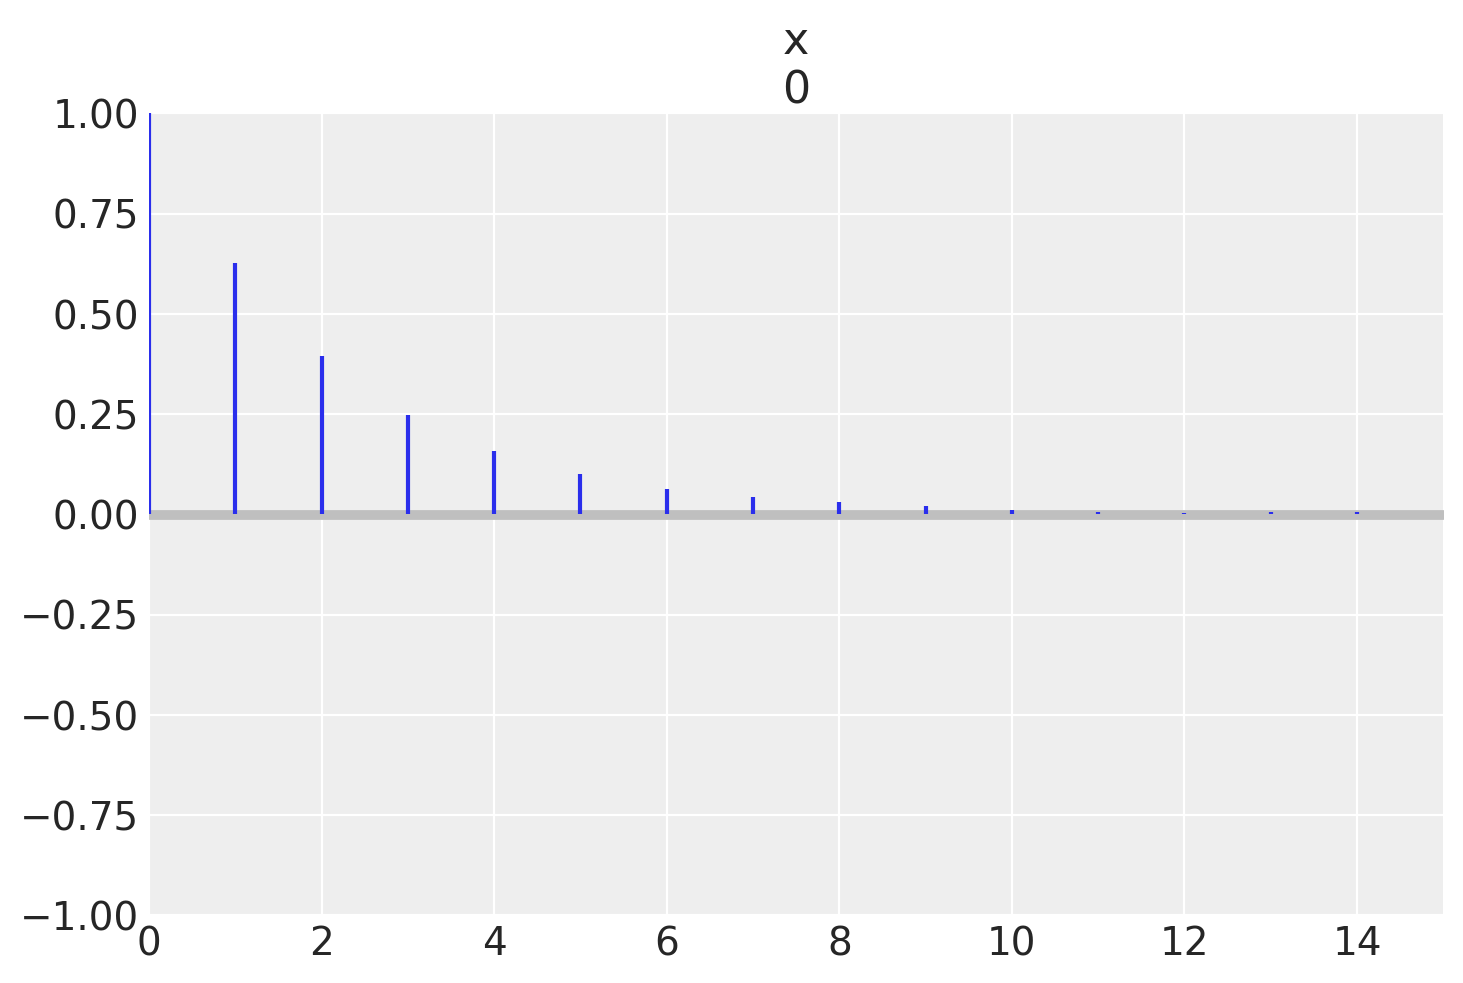

In [11]:
az.plot_autocorr(samps[40000::], max_lag=15)
plt.show()

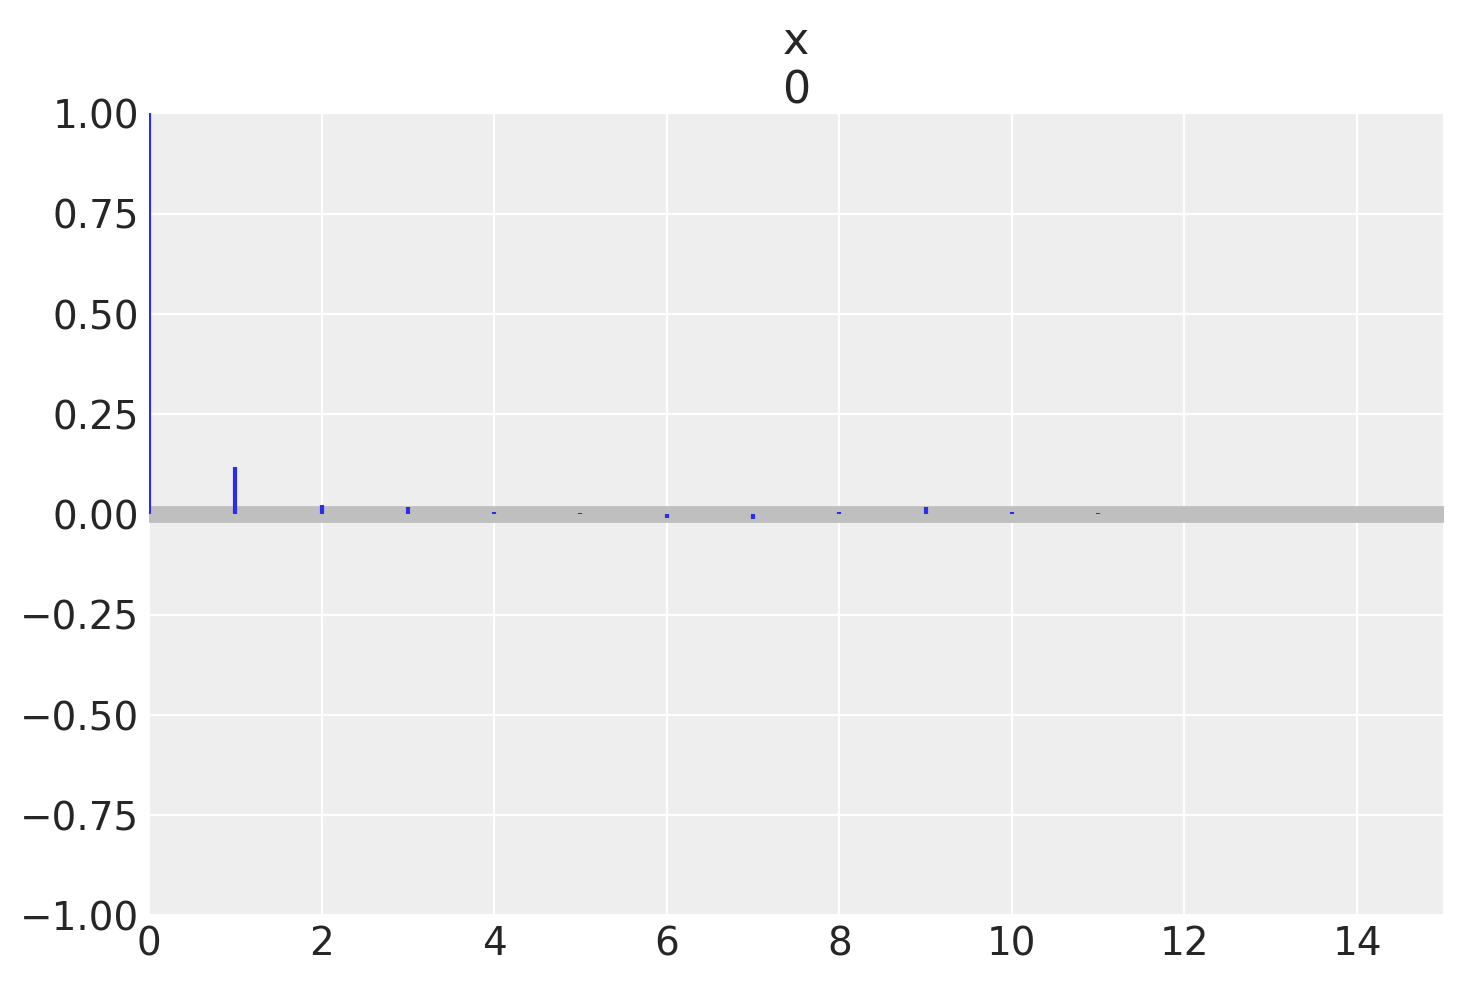

In [12]:
az.plot_autocorr(samps[40000::5], max_lag=15)
plt.show()

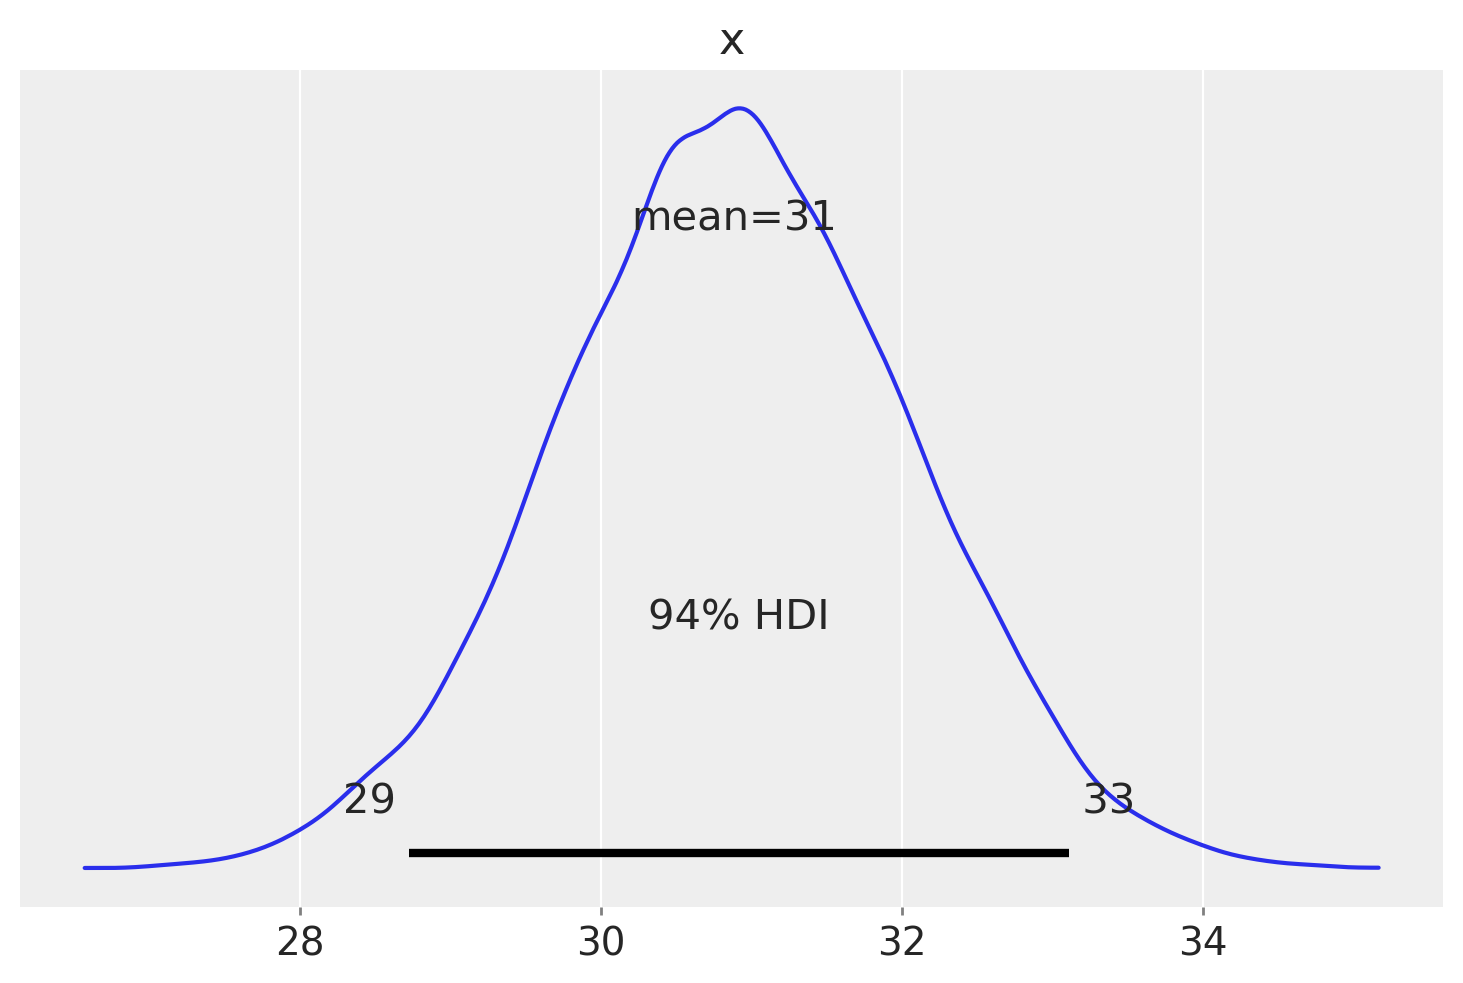

In [13]:
az.plot_posterior(samps[40000::5], hdi_prob=0.94)
plt.show()

In [14]:
az.hdi(samps[40000::5], hdi_prob=0.94)

array([28.72657267, 33.11022257])

In [15]:
sigma = np.std(df["y"])
sigma

6.495810615739622

In [16]:
with pm.Model() as model:
    data = pm.ConstantData("data", df["y"])
    mu = pm.Normal("mu", mu=30, sigma=5)
    pm.Normal("y", mu=mu, sigma=np.std(df["y"]), observed=data)

In [17]:
with model:
    idata = pm.sampling_jax.sample_numpyro_nuts()

Compiling...


Compilation time = 0:00:04.473011


Sampling...


  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

Running chain 1:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 3:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 0:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 2:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 0: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1866.78it/s]


Running chain 1: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1869.23it/s]


Running chain 2: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1871.75it/s]


Running chain 3: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1873.91it/s]


Sampling time = 0:00:01.290441


Transforming variables...


Transformation time = 0:00:00.060946


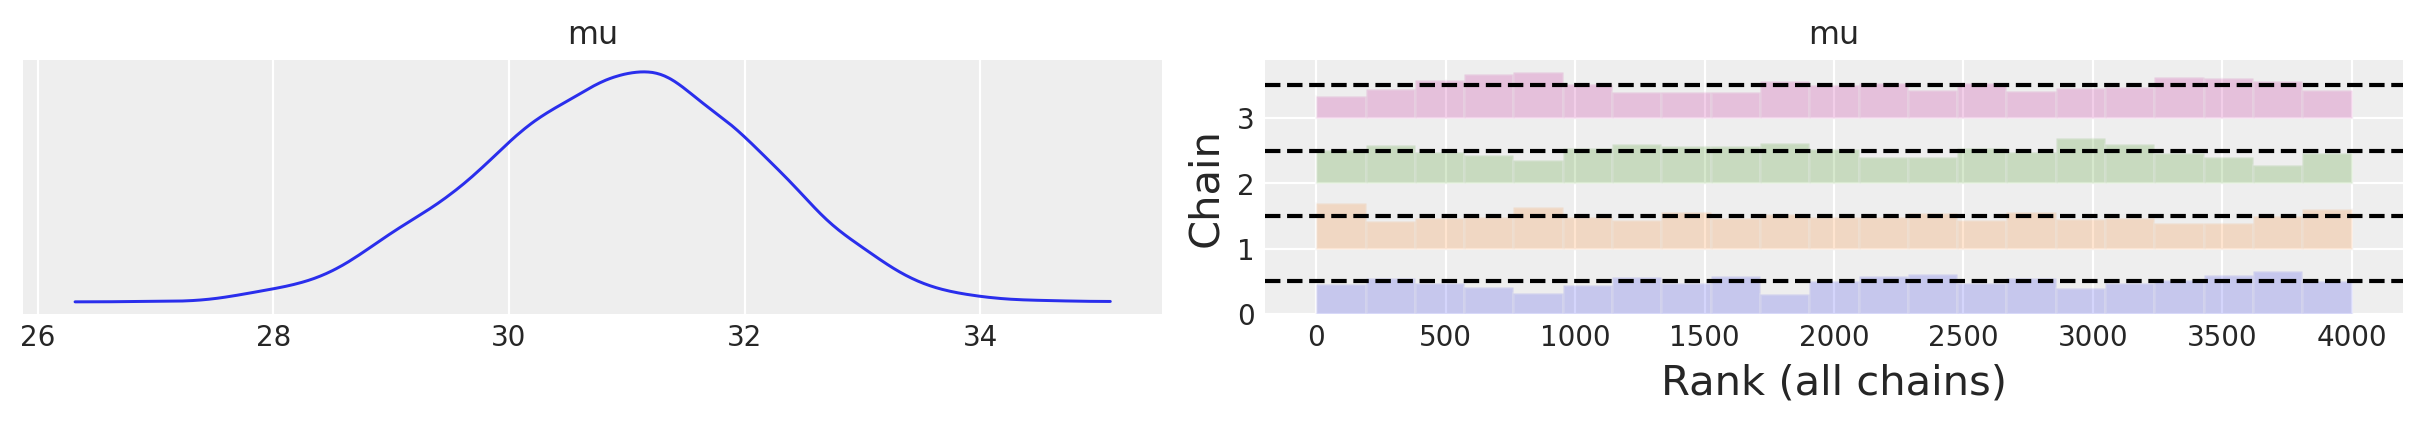

In [18]:
az.plot_trace(idata, combined=True, kind="rank_bars")
plt.show()

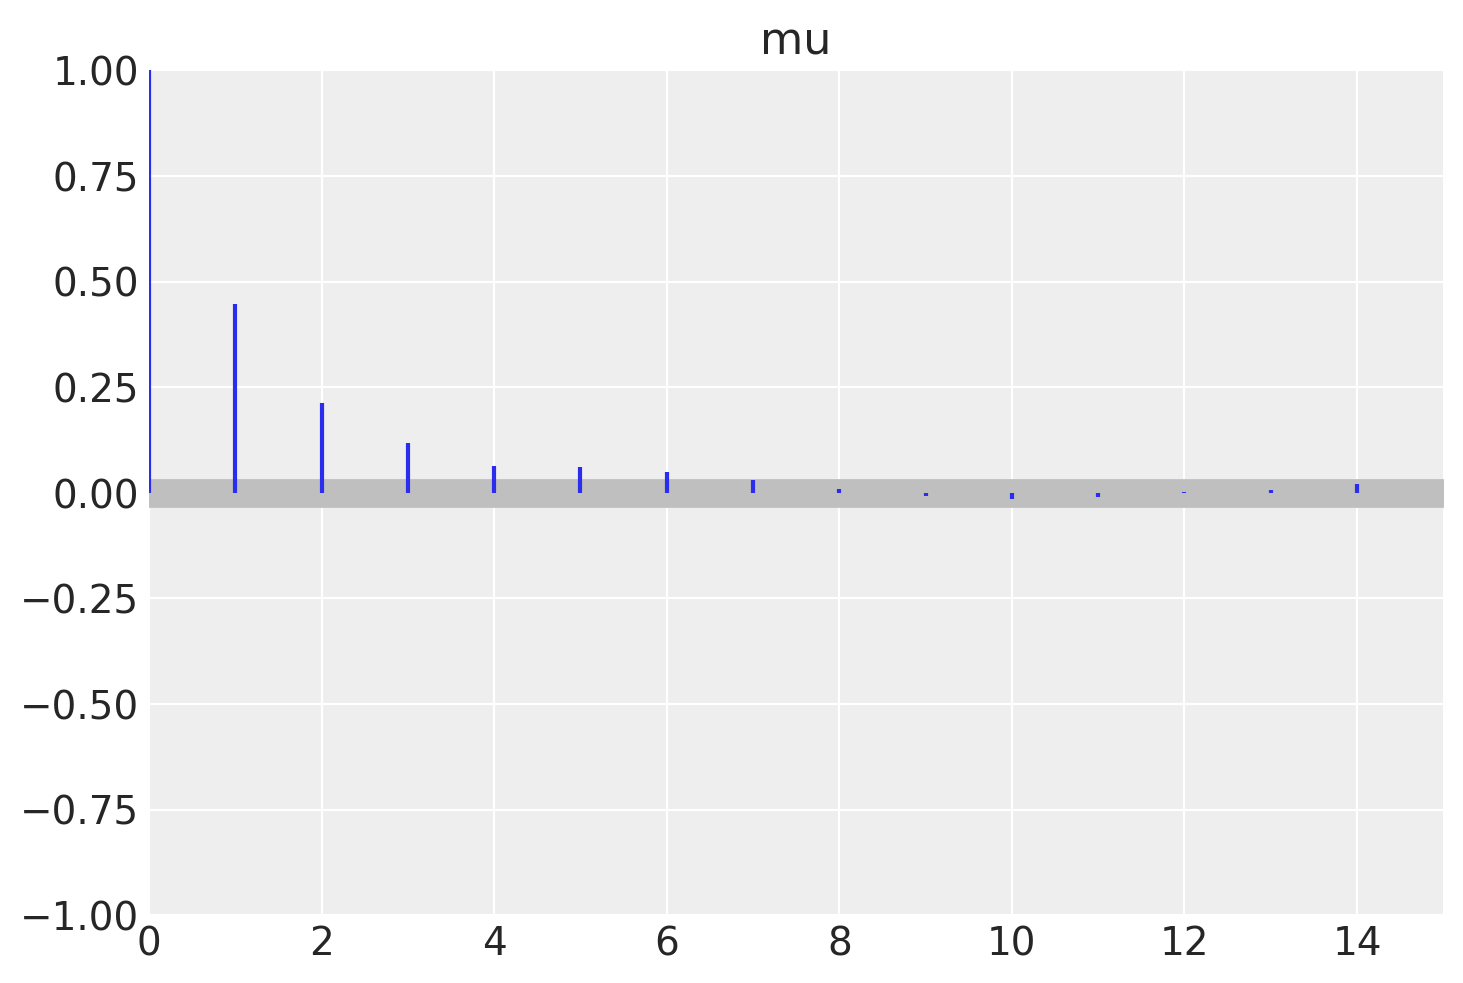

In [19]:
az.plot_autocorr(idata, combined=True, max_lag=15)
plt.show()

In [20]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,30.94,1.19,28.71,33.09,0.03,0.02,1352.74,1747.68,1.0


In [21]:
az.hdi(idata, hdi_prob=0.94)

<xarray.Dataset>
Dimensions:  (hdi: 2)
Coordinates:
  * hdi      (hdi) <U6 'lower' 'higher'
Data variables:
    mu       (hdi) float64 28.71 33.09

In [22]:
stats.norm.ppf([0.03, 0.97], loc=30.8836, scale=1.1539)

array([28.71335226, 33.05384774])

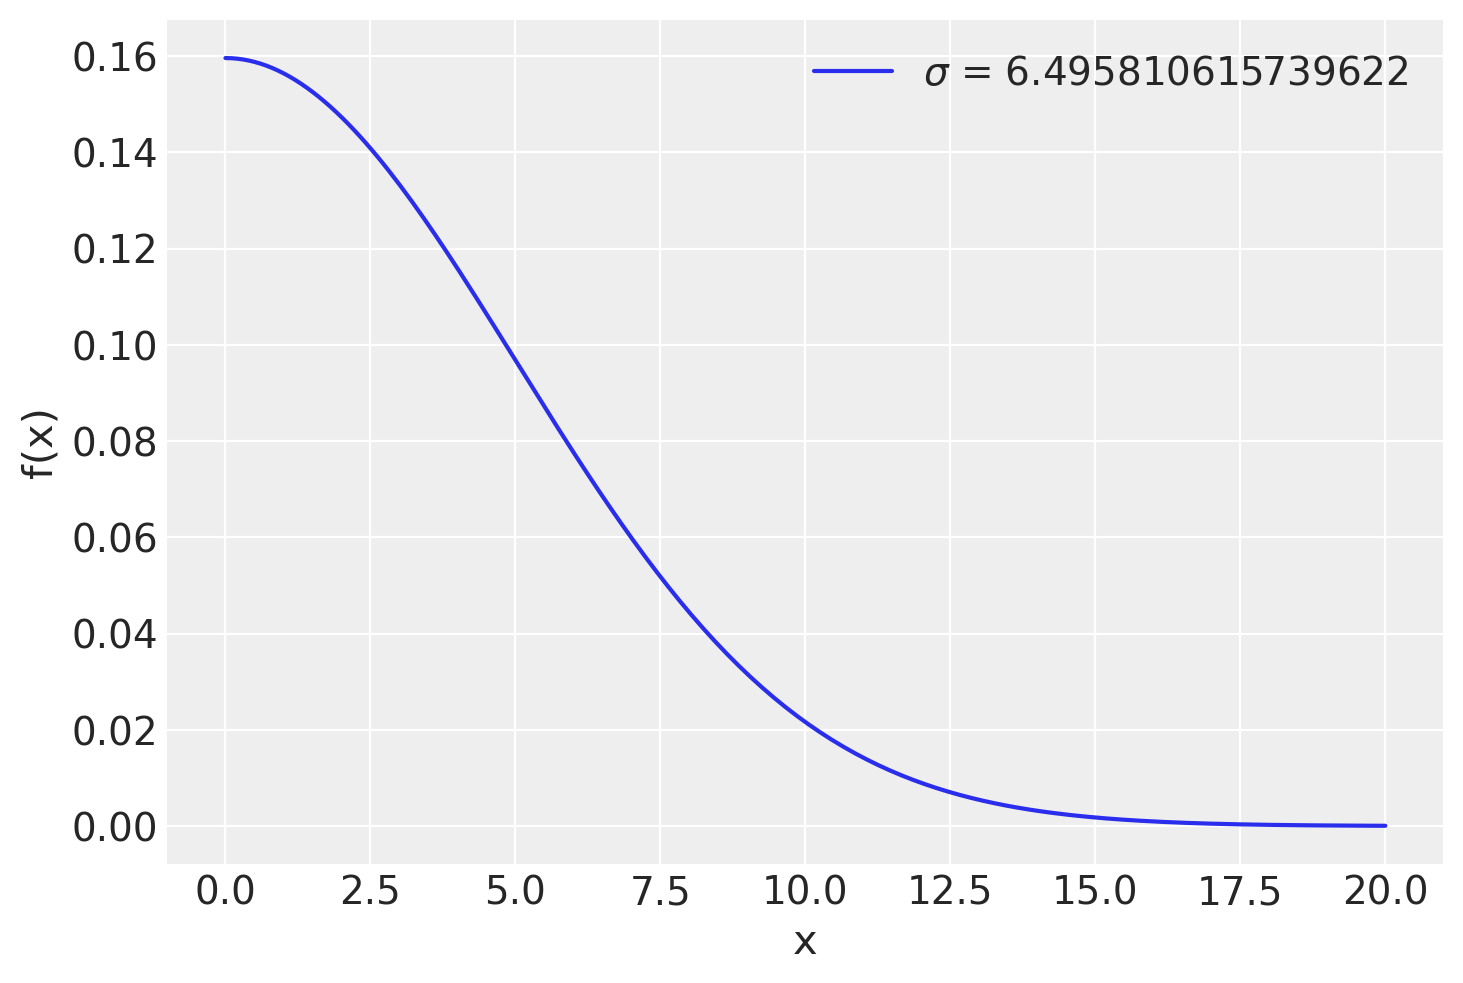

In [23]:
x = np.linspace(0, 20, 200)
pdf = stats.halfnorm.pdf(x, scale=5)
plt.plot(x, pdf, label=r'$\sigma$ = {}'.format(sigma))
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend(loc=1)
plt.show()

In [24]:
with pm.Model() as model2:
    data = pm.ConstantData("data", df["y"])
    mu = pm.Normal("mu", mu=30, sigma=5)
    sigma = pm.HalfNormal("sigma", sigma=10)
    pm.Normal("y", mu=mu, sigma=sigma, observed=data)

In [25]:
with model2:
    idata2 = pm.sampling_jax.sample_numpyro_nuts()

Compiling...


Compilation time = 0:00:00.660052


Sampling...


  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

Running chain 1:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 0:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 2:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 3:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 0: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1726.34it/s]


Running chain 1: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1727.74it/s]


Running chain 2: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1729.64it/s]


Running chain 3: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1731.36it/s]


Sampling time = 0:00:01.224292


Transforming variables...


Transformation time = 0:00:00.034863


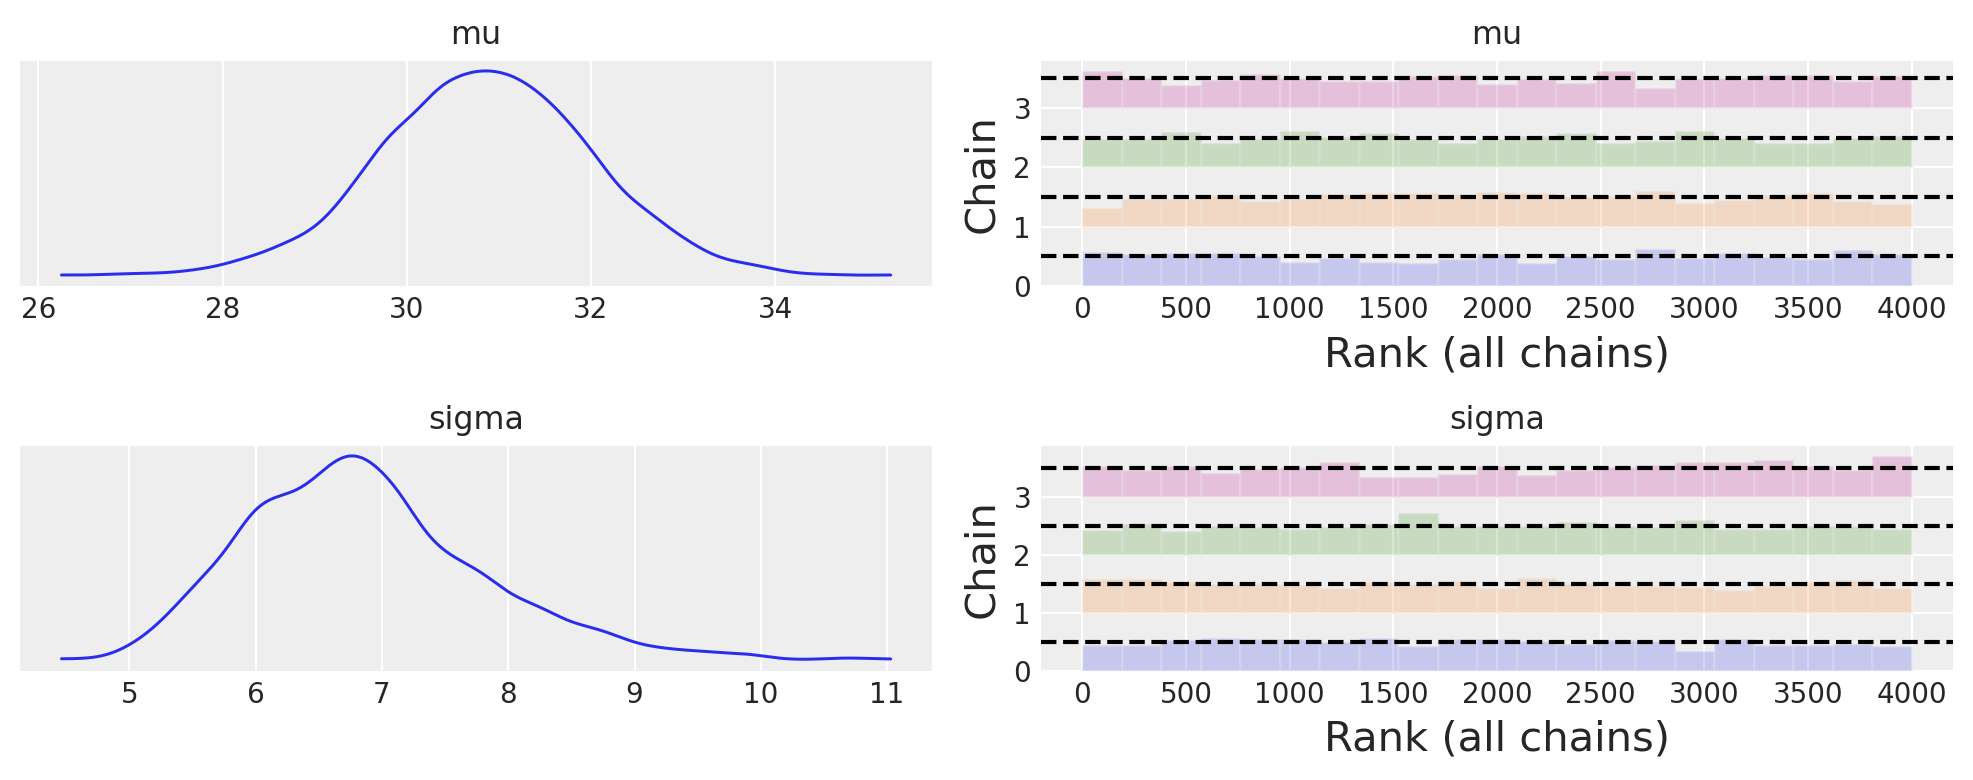

In [26]:
az.plot_trace(idata2, combined=True, kind="rank_bars", figsize=(10, 4))
plt.tight_layout()
plt.show()

In [27]:
az.summary(idata2, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,30.86,1.17,28.62,33.02,0.02,0.02,3051.42,2250.89,1.0
sigma,6.87,0.97,5.22,8.72,0.02,0.01,2766.97,2357.76,1.0


In [28]:
az.hdi(idata2, hdi_prob=0.94)

<xarray.Dataset>
Dimensions:  (hdi: 2)
Coordinates:
  * hdi      (hdi) <U6 'lower' 'higher'
Data variables:
    mu       (hdi) float64 28.62 33.02
    sigma    (hdi) float64 5.215 8.719

In [29]:
%run ../wm.py

Watermark:
----------
Last updated: 2024-01-26T18:59:31.880467+01:00

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.19.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit


